# Bomberle: CCNs

## Figure 1: Simple state representation

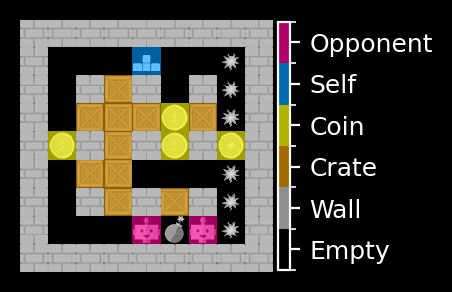

In [281]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from agent_code.user_agent.callbacks import state_to_cnn_features

from matplotlib.colors import ListedColormap, BoundaryNorm

# Paths
run_folder = "agent_code/user_agent/snapshots/20250927_180621/"
feature_file    = os.path.join(run_folder, "features_00014.npy")
screenshot_file = os.path.join(run_folder, "screenshot_00014.png")
state_file      = os.path.join(run_folder, "state_00014.pkl")

# Crop box (left, top, right_offset, bottom_offset)
CROP_BOX = (165, 165, -565, -165)

# --- Load data ---
features = np.load(feature_file)  # shape (9, 9, num_channels)
with open(state_file, "rb") as f:
    game_state = pickle.load(f)

# Load & crop screenshot, display as grayscale
img = Image.open(screenshot_file)
width, height = img.size
left, top = CROP_BOX[0], CROP_BOX[1]
right, bottom = width + CROP_BOX[2], height + CROP_BOX[3]
cropped = img.crop((left, top, right, bottom))
gray_bg = cropped.convert("L").convert("RGB")  # grayscale background
W, H = gray_bg.size

# --- Choose channels and build a simple categorical map (like your example) ---
channel_names = [
    "Wall", "Free", "Crate",
    "Bomb timer", "Danger", "Explosion",
    "Coin", "Self", "Opponent",
    "Self can bomb", "Opp can bomb"
]
channels_to_show = [0, 2, 6, 7, 8]

combined = np.zeros(features.shape[:2], dtype=int)
for idx, ch in enumerate(channels_to_show, start=1):
    combined += (features[..., ch] > 0).astype(int) * idx

# --- Upscale the 9x9 feature map to screenshot size with NEAREST ---
# (Transpose to keep the same orientation you had with imshow(combined.T))
combined_up = Image.fromarray(combined.T.astype(np.uint8)).resize((W, H), Image.NEAREST)
combined_up = np.array(combined_up)

# --- Plot overlay (simple) ---
os.makedirs("figures", exist_ok=True)
cmap = "rainbow"   # keep your choice; swap if you prefer
alpha = 0.7

labels = ["Empty", "Wall", "Crate", "Coin", "Self", "Opponent"]
# Define per-class RGBA colors (same length as labels)
# Tip: alpha < 1 lets the grayscale show through
colors = [
    (0.0, 0.0, 0.0, 0.0),  # Empty (fully transparent)
    (0.8, 0.8, 0.8, 0.9),  # Wall
    (0.9, 0.6, 0.0, 0.9),  # Crate
    (1.0, 1.0, 0.0, 0.9),  # Coin
    (0.0, 0.6, 1.0, 0.9),  # Self
    (1.0, 0.0, 0.6, 0.9),  # Opponent
]
cat_cmap = ListedColormap(colors)

# Map integer values to color bins: centers at 0,1,2,...; edges at -0.5,0.5,1.5,...
bounds = np.arange(len(labels) + 1) - 0.5
norm = BoundaryNorm(bounds, cat_cmap.N)

dpi = 200
fig = plt.figure(figsize=(W / dpi, H / dpi), dpi=dpi)
ax = plt.axes([0, 0, 1, 1])   # full-bleed
ax.imshow(gray_bg, cmap="gray", interpolation="nearest")
im = ax.imshow(combined_up, alpha=alpha, cmap=cat_cmap, norm=norm, interpolation="nearest")  # alpha is baked in colors

# Add vertical colorbar on the right with category names
cbar = fig.colorbar(im, ax=ax, orientation="vertical", fraction=0.046, pad=0.02)
cbar.set_ticks(np.arange(len(labels)))
cbar.set_ticklabels(labels)
cbar.ax.tick_params(labelsize=9)   # tweak as you like

ax.axis("off")

fig.savefig("figures/13_cnn_simple_representation.png", bbox_inches="tight", pad_inches=0.2)
plt.show()


## Figure 2: One-hot encoding

In [383]:
import os
import pickle
import random

import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

from q_deep_agent import DeepQAgent

from q_helpers import get_legal_actions, ACTS, N_ACTIONS, N_STATES, state_to_tabular_features, describe_tabular_state

from tensorflow.keras.utils import plot_model


model = tf.keras.models.load_model(r"agent_code/cnn_allstar_duel/snapshots/models/default_target_model.keras", safe_mode=False)

# Save to file
plot_model(model,
           to_file="figures/16_dqn_cnn_architecture.png",
           show_shapes=True,
           show_layer_names=True,
           expand_nested=True,
           dpi=150)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 9, 9, 11)]           0         []                            
                                                                                                  
 conv2d_3 (Conv2D)           (None, 9, 9, 64)             6400      ['input_2[0][0]']             
                                                                                                  
 conv2d_4 (Conv2D)           (None, 9, 9, 64)             36928     ['conv2d_3[0][0]']            
                                                                                                  
 conv2d_5 (Conv2D)           (None, 9, 9, 64)             36928     ['conv2d_4[0][0]']            
                                                                                            

In [ ]:
import os
import re
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from PIL import Image
from tensorflow.keras import models
import agent_code.cnn_allstar_duel.callbacks

# ---------------- CONFIG ----------------
run_folder = "agent_code/user_agent/snapshots/20250927_180621/"
output_folder = "figures/"
indices = np.arange(15)          # 00000 .. 00014
crop_box = (165, 165, -565, -165)
alpha = 0.5
max_input_channels = 11
max_conv_filters = 64
out_root = os.path.join(output_folder, "14_cnn_feature_channels")

# Input channel names (used in filenames)
channel_names = [
    "Wall", "Free", "Crate",
    "Bomb", "Danger", "Explosion",
    "Coin", "Player", "Opponent",
    "PlayerCanDrop", "OpponentCanDrop"
]

# ---------------- COLORMAP ----------------
cmap = mcolors.LinearSegmentedColormap.from_list("black_to_yellow", ["black", "yellow"])

# ---------------- HELPERS ----------------
def zpad(i, n=5): return str(i).zfill(n)

def sanitize(s):
    return re.sub(r"[^A-Za-z0-9_\-]+", "", s.replace(" ", "_"))

def normalize01(arr):
    arr = arr.astype(np.float32)
    mn = arr.min()
    mx = arr.max()
    arr = arr - mn
    if mx - mn > 1e-8:
        arr = arr / (mx - mn)
    return arr

def resize_to(img2d, W, H):
    # match your previous orientation (used .T in the original)
    return np.array(Image.fromarray(img2d.T).resize((W, H), Image.NEAREST), dtype=np.float32)

def save_overlay_img(
    screenshot_rgb,     # float32 HxWx3, 0..1
    overlay_01,         # float32 HxW, 0..1
    out_path,
    alpha=0.5,
    fmt=None,           # inferred from extension if None
    jpg_quality=85,     # 80–90 is a good balance
    jpg_subsampling=2,  # 4:2:0 chroma, smaller files
    jpg_optimize=True,
    jpg_progressive=True,
    webp_quality=80     # if you choose .webp
):
    overlay_01 = np.clip(overlay_01, 0.0, 1.0).astype(np.float32)
    base = np.clip(screenshot_rgb, 0.0, 1.0).astype(np.float32)

    # colormap "black → yellow": (v, v, 0)
    overlay_rgb = np.stack([overlay_01, overlay_01, np.zeros_like(overlay_01)], axis=-1)

    # alpha blend
    out = base * (1.0 - alpha) + overlay_rgb * alpha
    out_img = Image.fromarray(np.round(out * 255).astype(np.uint8), mode="RGB")

    dpi = 100
    pad_inches = 0.2
    pad_color = (0, 0, 0)

    # === padding in inches (like pad_inches in matplotlib) ===
    if pad_inches and pad_inches > 0:
        pad_px = int(round(pad_inches * dpi))
        W, H = out_img.size
        canvas = Image.new("RGB", (W + 2 * pad_px, H + 2 * pad_px), pad_color)
        canvas.paste(out_img, (pad_px, pad_px))
        out_img = canvas

    ext = (os.path.splitext(out_path)[1] or "").lower()
    fmt = fmt or {".jpg": "JPEG", ".jpeg": "JPEG", ".webp": "WEBP", ".png": "PNG"}.get(ext, "PNG")

    if fmt == "JPEG":
        out_img.save(
            out_path,
            format="JPEG",
            quality=jpg_quality,
            subsampling=jpg_subsampling,   # 0=4:4:4 (bigger, cleaner), 2=4:2:0 (smaller)
            optimize=jpg_optimize,
            progressive=jpg_progressive,
        )
    elif fmt == "WEBP":
        out_img.save(out_path, format="WEBP", quality=webp_quality, method=6)
    else:
        # Smallest lossless PNG (if you want PNG sometimes)
        out_img.save(out_path, format="PNG", optimize=True, compress_level=9)

# ---------------- BUILD ACTIVATION MODEL ONCE ----------------
# Select convolutional layers and prepare a model that outputs their activations
conv_layers = [layer for layer in model.layers if "conv" in layer.name]
layer_outputs = [layer.output for layer in conv_layers]
activation_model = models.Model(
    inputs=model.input,
    outputs=layer_outputs
)
# ---------------- MAIN LOOP ----------------
os.makedirs(out_root, exist_ok=True)

for idx in indices:
    stem = zpad(idx)
    feature_file   = os.path.join(run_folder, f"features_{stem}.npy")
    screenshot_file= os.path.join(run_folder, f"screenshot_{stem}.png")
    state_file     = os.path.join(run_folder, f"state_{stem}.pkl")  # not used but loaded if needed

    if not (os.path.isfile(feature_file) and os.path.isfile(screenshot_file)):
        print(f"[skip] Missing files for index {stem}")
        continue

    # ---- load features and screenshot ----
    features = np.load(feature_file)  # (H_in, W_in, C)
    if features.ndim == 4 and features.shape[0] == 1:
        features = features[0]

    img = Image.open(screenshot_file)
    width, height = img.size
    l, t, ro, bo = crop_box
    r, b = width + ro, height + bo
    screenshot_img = img.crop((l, t, r, b)).convert("L").convert("RGB")
    W, H = screenshot_img.size
    screenshot_arr = np.asarray(screenshot_img).astype(np.float32) / 255.0

    # ---- input overlays ----
    H_in, W_in, C_in = features.shape
    n_in = min(C_in, max_input_channels)

    # make out dirs
    base_dir = os.path.join(out_root, stem)
    input_dir = os.path.join(base_dir, "input")
    os.makedirs(input_dir, exist_ok=True)

    for c in range(n_in):
        ch_name = channel_names[c] if c < len(channel_names) else f"Channel{c}"
        overlay = normalize01(features[:, :, c])
        overlay = resize_to(overlay, W, H)
        out_name = f"input_{c:02d}_{sanitize(ch_name)}.jpg"
        out_path = os.path.join(input_dir, out_name)
        save_overlay_img(screenshot_arr, overlay, out_path, alpha=alpha)

    # ---- conv activations ----
    # forward pass: shape list, each (1, h, w, channels)
    sample_input = features.reshape(1, H_in, W_in, C_in)
    activations = activation_model.predict(sample_input, verbose=0)

    for layer, act in zip(conv_layers, activations):
        layer_name = sanitize(layer.name)
        layer_dir = os.path.join(base_dir, f"conv_{layer_name}")
        os.makedirs(layer_dir, exist_ok=True)

        n_filters = min(act.shape[-1], max_conv_filters)
        for fidx in range(n_filters):
            a = normalize01(act[0, :, :, fidx])
            a = resize_to(a, W, H)
            out_name = f"{layer_name}_f{fidx:02d}.jpg"
            out_path = os.path.join(layer_dir, out_name)
            save_overlay_img(screenshot_arr, a, out_path, alpha=alpha)

    print(f"[done] {stem} → {base_dir}")


[done] 00000 → figures/14_cnn_feature_channels/00000
[done] 00001 → figures/14_cnn_feature_channels/00001
[done] 00002 → figures/14_cnn_feature_channels/00002
[done] 00003 → figures/14_cnn_feature_channels/00003
[done] 00004 → figures/14_cnn_feature_channels/00004
[done] 00005 → figures/14_cnn_feature_channels/00005
[done] 00006 → figures/14_cnn_feature_channels/00006
[done] 00007 → figures/14_cnn_feature_channels/00007
[done] 00008 → figures/14_cnn_feature_channels/00008
[done] 00009 → figures/14_cnn_feature_channels/00009
[done] 00010 → figures/14_cnn_feature_channels/00010
[done] 00011 → figures/14_cnn_feature_channels/00011
[done] 00012 → figures/14_cnn_feature_channels/00012
[done] 00013 → figures/14_cnn_feature_channels/00013
[done] 00014 → figures/14_cnn_feature_channels/00014


## Figure 4: The CNN allstar in action

`python3 main.py play --agents cnn_allstar_duel rule_based_agent peaceful_agent tq_representator --make-video`

In [388]:
from PIL import Image
import os
import re

# Path to folder with your images
folder = 'screenshots/cnn_allstar'

# Updated regex to match any round number (e.g., Round 01, Round 02, etc.)
pattern = re.compile(r'^Round (\d+).*\_(\d+)\.png$')

# List and sort matching files by round number and then by frame number
files = sorted(
    [f for f in os.listdir(folder) if pattern.match(f)],
    key=lambda f: (int(pattern.match(f).group(1)), int(pattern.match(f).group(2)))
)


# Optionally select a subset
selected_files = files


image_paths = [os.path.join(folder, f) for f in selected_files]

# Define crop box: (left, top, right, bottom)
# Example: remove a 10-pixel border on all sides
CROP_BOX = (125, 125, -525, -125)  # negative values mean relative to image size

frames = []
for path in image_paths:
    img = Image.open(path)
    width, height = img.size

    # Compute absolute crop box
    left = CROP_BOX[0]
    top = CROP_BOX[1]
    right = width + CROP_BOX[2]  # e.g., -10 becomes width - 10
    bottom = height + CROP_BOX[3]

    cropped = img.crop((left, top, right, bottom))

    # Create new image with transparent border
    border_size = 8
    bordered = Image.new("RGBA",
                         (cropped.width + 2 * border_size, cropped.height + 2 * border_size),
                         (0, 0, 0, 0))  # fully transparent
    bordered.paste(cropped, (border_size, border_size))

    # Convert to P mode but keep transparency
    frames.append(bordered.convert("P", palette=Image.ADAPTIVE))

# Save to GIF
output_path = 'figures/16_cnn_allstar.gif'
frames[0].save(
    output_path,
    save_all=True,
    append_images=frames[1:],
    duration=100,
    loop=0,
    optimize=True

)

## Figure 5: Extrapolating to the unseen

In [ ]:
from PIL import Image
import os
import re

# Path to folder with your images
folder = 'screenshots/cnn_coin_grabber'

# Regex to match filenames like: "Round 01 (2025-07-24 09-46-17)_00001.png"
pattern = re.compile(r'^Round 04.*_(\d+)\.png$')

# List and sort matching files by frame number
files = sorted(
    [f for f in os.listdir(folder) if pattern.match(f)],
    key=lambda f: int(pattern.match(f).group(1))
)
print(files)

# Optionally select a subset
selected_files = files


image_paths = [os.path.join(folder, f) for f in selected_files]

# Define crop box: (left, top, right, bottom)
# Example: remove a 10-pixel border on all sides
CROP_BOX = (125, 125, -525, -125)  # negative values mean relative to image size

frames = []
for path in image_paths:
    img = Image.open(path)
    width, height = img.size

    # Compute absolute crop box
    left = CROP_BOX[0]
    top = CROP_BOX[1]
    right = width + CROP_BOX[2]  # e.g., -10 becomes width - 10
    bottom = height + CROP_BOX[3]

    cropped = img.crop((left, top, right, bottom))

    # Create new image with transparent border
    border_size = 8
    bordered = Image.new("RGBA",
                         (cropped.width + 2 * border_size, cropped.height + 2 * border_size),
                         (0, 0, 0, 0))  # fully transparent
    bordered.paste(cropped, (border_size, border_size))

    # Convert to P mode but keep transparency
    frames.append(bordered.convert("P", palette=Image.ADAPTIVE))

# Save to GIF
output_path = 'figures/17_cnn_coin_grabber.gif'
frames[0].save(
    output_path,
    save_all=True,
    append_images=frames[1:],
    duration=100,
    loop=0,
    optimize=True

)

['Round 04 (2025-09-28 18-30-05)_00185.png', 'Round 04 (2025-09-28 18-30-05)_00186.png', 'Round 04 (2025-09-28 18-30-05)_00187.png', 'Round 04 (2025-09-28 18-30-05)_00188.png', 'Round 04 (2025-09-28 18-30-05)_00189.png', 'Round 04 (2025-09-28 18-30-05)_00190.png', 'Round 04 (2025-09-28 18-30-05)_00191.png', 'Round 04 (2025-09-28 18-30-05)_00192.png', 'Round 04 (2025-09-28 18-30-05)_00193.png', 'Round 04 (2025-09-28 18-30-05)_00194.png', 'Round 04 (2025-09-28 18-30-05)_00195.png', 'Round 04 (2025-09-28 18-30-05)_00196.png', 'Round 04 (2025-09-28 18-30-05)_00197.png', 'Round 04 (2025-09-28 18-30-05)_00198.png', 'Round 04 (2025-09-28 18-30-05)_00199.png', 'Round 04 (2025-09-28 18-30-05)_00200.png', 'Round 04 (2025-09-28 18-30-05)_00201.png', 'Round 04 (2025-09-28 18-30-05)_00202.png', 'Round 04 (2025-09-28 18-30-05)_00203.png', 'Round 04 (2025-09-28 18-30-05)_00204.png', 'Round 04 (2025-09-28 18-30-05)_00205.png', 'Round 04 (2025-09-28 18-30-05)_00206.png', 'Round 04 (2025-09-28 18-30-05)

## Figure 6: The training process of the CNN allstar

In [2]:
#!/usr/bin/env python3
import os
import re
import json
import numpy as np
import matplotlib.pyplot as plt

def _npz_item(data, key, default=None):
    """Safely unwrap a 0-D object array from an npz (saved via np.array(obj, dtype=object))."""
    if key in data.files:
        return data[key].item()
    return default

def _collect_npz_files_with_chunk_indices(folder):
    """
    Return dict: chunk_idx -> path for all .npz files in folder.
    Prefer parsing from filename '*_chunk_####.npz'; fallback to reading meta.chunk_idx.
    """
    npz_files = {}
    name_pat = re.compile(r".*_chunk_(\d+)\.npz$")
    for f in os.listdir(folder):
        if not f.endswith(".npz"):
            continue
        path = os.path.join(folder, f)
        m = name_pat.match(f)
        if m:
            npz_files[int(m.group(1))] = path
            continue
        # Fallback: open and read meta.chunk_idx
        try:
            with np.load(path, allow_pickle=True) as data:
                meta = _npz_item(data, "meta", {}) or {}
                ci = meta.get("chunk_idx", None)
                if ci is not None:
                    npz_files[int(ci)] = path
        except Exception:
            # Ignore unreadable files
            pass
    return npz_files

def load_q_visits_snapshots(folder, agent=None):
    """Load q_visits from NPZ snapshots and matching evaluation JSON results."""
    # Find NPZ snapshots and eval JSONs
    eval_pat = re.compile(r"eval_chunk_(\d+)\.json$")
    eval_files = {}
    for f in os.listdir(folder):
        m = eval_pat.match(f)
        if m:
            eval_files[int(m.group(1))] = os.path.join(folder, f)

    # Only keep chunks where we have both NPZ and eval
    chunk_indices = sorted(set(eval_files.keys()))

    total_counts = []
    unique_counts = []
    avg_scores = []

    for idx in chunk_indices:
        # --- Load Evaluation JSON ---
        with open(eval_files[idx], "r") as f:
            eval_data = json.load(f)

        agent_data = None
        by_agent = eval_data.get("by_agent", {})

        if agent is None:
            # Pick the first agent name containing 'tq'
            for agent_name, stats in by_agent.items():
                if "tq" in agent_name:
                    agent_data = stats
                    break
            if agent_data is None and by_agent:
                # Fallback to any agent if none has 'tq'
                first_key = next(iter(by_agent))
                agent_data = by_agent[first_key]
        else:
            if agent not in by_agent:
                raise KeyError(f"Agent '{agent}' not found in eval for chunk {idx}. "
                               f"Available: {list(by_agent.keys())}")
            agent_data = by_agent[agent]

        # Score heuristic: prefer 'score', else coins + 5*kills
        score_total = agent_data.get("score", None)
        if score_total is None:
            score_total = agent_data.get("coins", 0) + 5 * agent_data.get("kills", 0) - 5 * agent_data.get("suicides", 0)

        rounds = max(1, int(agent_data.get("rounds", 1)))
        avg_score = score_total / rounds

        # Append metrics
        avg_scores.append(avg_score)

    return chunk_indices, avg_scores


In [38]:

c3, t3 = load_q_visits_snapshots("agent_code/cnn_allstar_duel_pretrain/snapshots/dicts", agent="cnn_allstar_duel_pretrain")
c4, t4 = load_q_visits_snapshots("agent_code/cnn_allstar_duel_pretrain/snapshots/dicts", agent="peaceful_agent")
c5, t5 = load_q_visits_snapshots("agent_code/cnn_allstar_duel_pretrain/snapshots/dicts", agent="rule_based_agent_0")
c6, t6 = load_q_visits_snapshots("agent_code/cnn_allstar_duel_pretrain/snapshots/dicts", agent="rule_based_agent_1")

In [386]:

c3, t3 = load_q_visits_snapshots("agent_code/cnn_allstar_duel/dicts", agent="cnn_allstar_duel")
c4, t4 = load_q_visits_snapshots("agent_code/cnn_allstar_duel/dicts", agent="peaceful_agent")
c5, t5 = load_q_visits_snapshots("agent_code/cnn_allstar_duel/dicts", agent="rule_based_agent")
c6, t6 = load_q_visits_snapshots("agent_code/cnn_allstar_duel/dicts", agent="tq_representator")

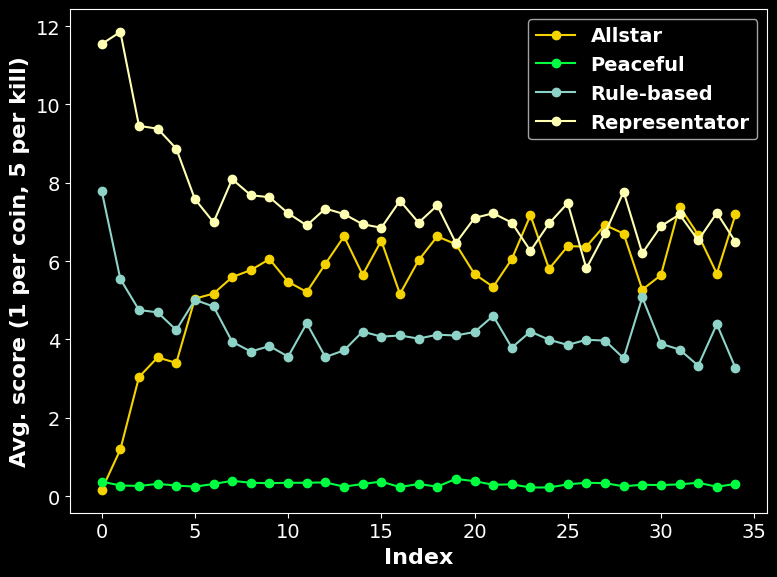

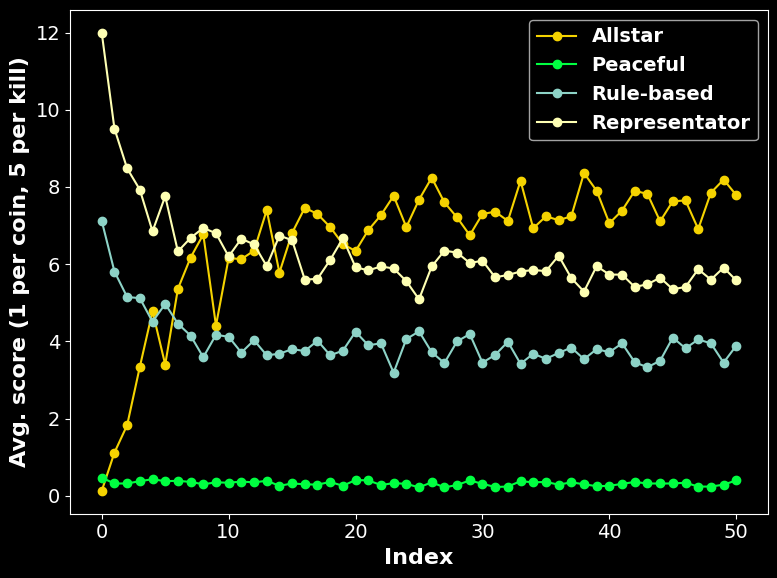

In [387]:

import matplotlib.pyplot as plt
import numpy as np

# Use dark background
plt.style.use('dark_background')

# Glowing line style setup
linewidths     = np.logspace(-5, 5, 20, base=2)
transparencies = np.linspace(1, 0, 20)

# Neon color palette
neon_colors = [
    '#08F7FE',  # Coingrabber - neon cyan
    '#FE53BB',  # Cratehero - neon pink
    '#F5D300',  # Allstar - neon yellow
    '#00FF41',  # Rule-based agent - neon green (only for second plot)
]


plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["DejaVu Sans"],  # Or any available sans-serif font
    "font.size": 14,                     # Base font size
    "axes.labelweight": "bold",         # Make axis labels bold
    "axes.titlesize": 16,               # Title font size if used
    "axes.labelsize": 16,               # Axis label size
    "legend.fontsize": 14,              # Legend font size
    "legend.title_fontsize": 14,        # Legend title size (if used)
})

# ----------- Plot 1: Average evaluation score ------------
plt.figure(figsize=(8, 6))

# Final visible lines with labels
plt.plot(c3, t3, label="Allstar", c=neon_colors[2], marker='o')
plt.plot(c4, t4, label="Peaceful", c=neon_colors[3], marker='o')
plt.plot(c5, t5, label="Rule-based", marker='o')
plt.plot(c6, t6, label="Representator", marker='o')

plt.xlabel("Index")
plt.ylabel("Avg. score (1 per coin, 5 per kill)")
plt.legend(prop=dict(weight='bold'))
plt.tight_layout()
plt.show()



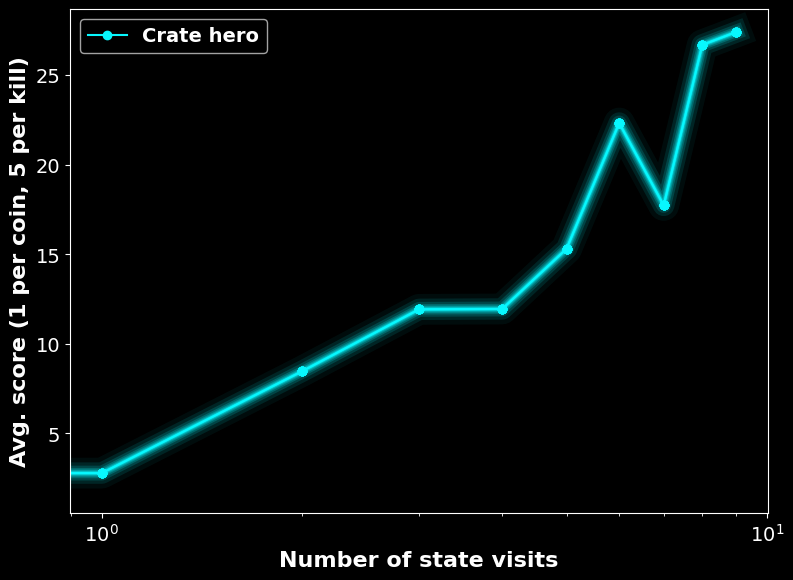

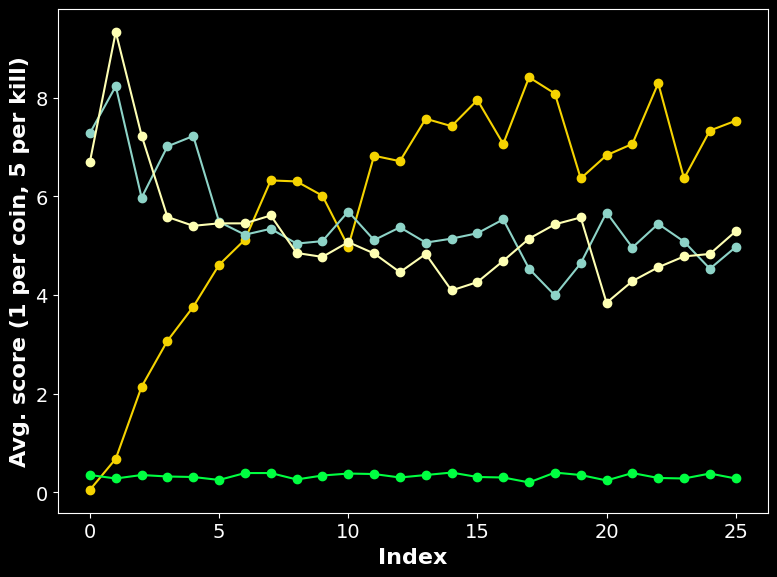

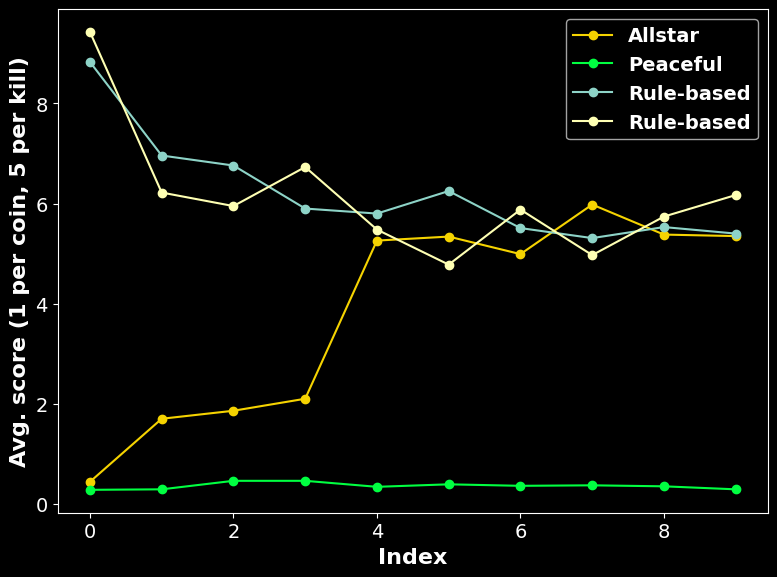

In [ ]:
import json
fn1 = "agent_code/cnn_allstar_duel/snapshots/experiment_29_training_log.json"
fn2 = "agent_code/cnn_allstar_duel/snapshots/experiment_04_training_log.json"


# Open and load JSON file
with open(fn1, 'r') as file:
    data  = json.load(file)

# Open and load JSON file
with open(fn2, 'r') as file:
    data2 = json.load(file)
# Now `data` is a Python dictionary (or list, depending on the JSON structure)
for v in data2:
    print(v)

{'training_round': 0, 'gradient_step': 0, 'loss': 0.023157520219683647}
{'training_round': 0, 'gradient_step': 1, 'loss': 0.02133096009492874}
{'training_round': 0, 'gradient_step': 2, 'loss': 0.01794973388314247}
{'training_round': 0, 'gradient_step': 3, 'loss': 0.013799733482301235}
{'training_round': 1, 'gradient_step': 0, 'loss': 0.012875359505414963}
{'training_round': 1, 'gradient_step': 1, 'loss': 0.009683936834335327}
{'training_round': 1, 'gradient_step': 2, 'loss': 0.014350119046866894}
{'training_round': 1, 'gradient_step': 3, 'loss': 0.00831863097846508}
{'training_round': 2, 'gradient_step': 0, 'loss': 0.013149388134479523}
{'training_round': 2, 'gradient_step': 1, 'loss': 0.02256949618458748}
{'training_round': 2, 'gradient_step': 2, 'loss': 0.007296192459762096}
{'training_round': 2, 'gradient_step': 3, 'loss': 0.011028802022337914}
{'training_round': 3, 'gradient_step': 0, 'loss': 0.013676377944648266}
{'training_round': 3, 'gradient_step': 1, 'loss': 0.0076568434014916

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


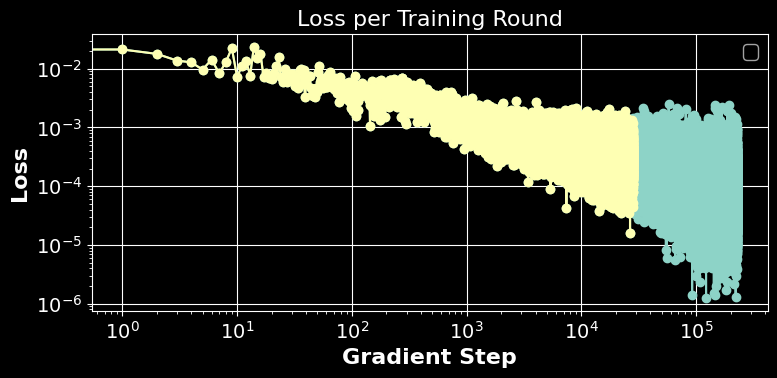

In [20]:
from matplotlib import pyplot as plt

# Option 1: Plot loss over global gradient step
x1 = list(range(len(data)))
y1 = [entry['loss'] for entry in data]

x2 = list(range(len(data2)))
y2 = [entry['loss'] for entry in data2]
plt.figure(figsize=(8, 4))
plt.plot(x1, y1, marker='o')
plt.plot(x2, y2, marker='o')
plt.title('Loss per Training Round')
plt.xlabel('Gradient Step')
plt.ylabel('Loss')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Total number of states:

Which agent plays best?

`python3 main.py play --agents cnn_allstar_duel peaceful_agent rule_based_agent tq_representator --n-rounds 1000 --save-stats --no-gui`

In [1]:
import json
import pandas as pd

# --- Load Evaluation JSON ---
with open("results/2025-09-11 13-14-00.json", "r") as f:
    eval_data = json.load(f)


# Extract agent names and scores
data = []

# Get the list of all categories (keys from the first agent's scores)
all_categories = list(next(iter(eval_data["by_agent"].values())).keys())

# Iterate through the agents and ensure all attributes are present
for agent_name, scores in eval_data["by_agent"].items():
    row = [agent_name]
    for category in all_categories:
        # Add the score if available, otherwise add 0 for missing categories
        row.append(f"{scores.get(category, 0) / 1000:.2g}")
    data.append(row)

# Create a DataFrame
df = pd.DataFrame(data, columns=["Agent"] + all_categories)

# Display the DataFrame vertically (transposed)
df.T  # This will transpose the table in Jupyter


,0,1,2,3
Agent,cnn_allstar_duel,peaceful_agent,rule_based_agent,tq_representator
bombs,25,0,6.7,15
coins,3,0.33,2,3.4
crates,5.5,0,6.5,8.6
invalid,2,19,3.7,3.6
kills,0.7,0,0.38,0.56
moves,1.5e+02,15,1e+02,1.8e+02
rounds,1,1,1,1
score,6.5,0.33,3.9,6.2
steps,2.8e+02,34,1.2e+02,2e+02


In [7]:
import json
import pandas as pd

# --- Load Evaluation JSON ---
with open("results/2025-09-27 08-40-10.json", "r") as f:
    eval_data = json.load(f)


# Extract agent names and scores
data = []

# Get the list of all categories (keys from the first agent's scores)
all_categories = list(next(iter(eval_data["by_agent"].values())).keys())

# Iterate through the agents and ensure all attributes are present
for agent_name, scores in eval_data["by_agent"].items():
    row = [agent_name]
    for category in all_categories:
        # Add the score if available, otherwise add 0 for missing categories
        row.append(f"{scores.get(category, 0) / 1000:.2g}")
    data.append(row)

# Create a DataFrame
df = pd.DataFrame(data, columns=["Agent"] + all_categories)

# Display the DataFrame vertically (transposed)
df.T  # This will transpose the table in Jupyter


,0,1,2,3
Agent,cnn_allstar_duel,peaceful_agent,rule_based_agent,tq_representator
bombs,42,0,7.3,11
coins,2.7,0.33,2,3.8
crates,6.3,0,6,8.3
invalid,2,19,4.1,3.3
kills,0.93,0,0.38,0.59
moves,2.4e+02,15,90,1.3e+02
rounds,1,1,1,1
score,7.3,0.33,3.9,6.7
steps,3e+02,34,1.1e+02,1.5e+02


In [28]:
# Start Markdown table (first row with agents)
markdown_output = "| Category | " + " | ".join(eval_data["by_agent"].keys()) + " |\n"
markdown_output += "|----------|-" + "|".join(["-" * len(agent) for agent in eval_data["by_agent"].keys()]) + "|\n"

# Add rows for each category (Score 1, Score 2, etc.)
categories = next(iter(eval_data["by_agent"].values())).keys()
for category in categories:
    markdown_output += f"| {category} | " + " | ".join([
        f"{scores.get(category, 0) / 1000:.2g}" for scores in eval_data["by_agent"].values()
    ]) + " |\n"

print(markdown_output)

| Category | tq_allstar | peaceful_agent | rule_based_agent | tq_representator |
|----------|-----------|--------------|----------------|----------------|
| bombs | 18 | 0 | 8 | 19 |
| coins | 3.5 | 0.33 | 2.1 | 3 |
| crates | 6.5 | 0 | 6.3 | 8.1 |
| invalid | 2.1 | 18 | 4.7 | 3.4 |
| kills | 0.57 | 0 | 0.48 | 0.62 |
| moves | 1.3e+02 | 14 | 69 | 1.3e+02 |
| rounds | 1 | 1 | 1 | 1 |
| score | 6.3 | 0.33 | 4.5 | 6.1 |
| steps | 1.5e+02 | 33 | 84 | 1.5e+02 |
| suicides | 0.61 | 0 | 0.34 | 0.52 |
| time | 0.08 | 0.00099 | 0.04 | 0.061 |



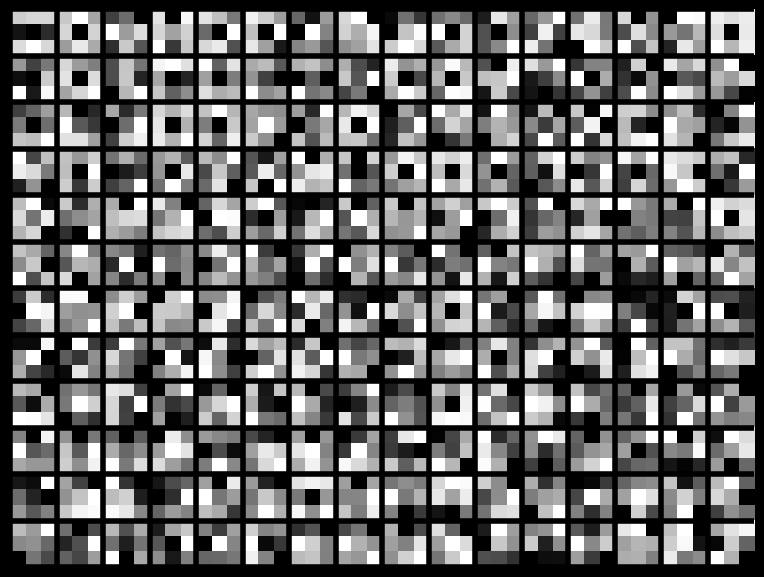

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt

def combined_filters_square(
    model,
    layer_names,
    filters_per_layer=64,
    channel=0,
    save_png_path=None
):
    """
    Create one bitmap with filters arranged in 4 rows × 16 columns per layer.
    Each filter is a 3x3 kernel (first input channel).
    Layers are stacked vertically.
    White gridlines delineate each 3x3 filter.
    """
    kernels = []
    for name in layer_names:
        layer = model.get_layer(name=name)
        w, b = layer.get_weights()
        kh, kw, in_ch, out_ch = w.shape
        assert (kh, kw) == (3, 3), "This function assumes 3x3 kernels"

        nf = min(out_ch, filters_per_layer)
        k = w[:, :, channel, :nf]   # shape: (3,3,nf)
        kernels.append(k)

    L = len(layer_names)
    rows_per_layer = 4
    cols_per_layer = 16
    assert rows_per_layer * cols_per_layer == filters_per_layer

    H = L * rows_per_layer * 3
    W = cols_per_layer * 3
    mosaic = np.zeros((H, W))

    for li, k3 in enumerate(kernels):  # (3,3,nf)
        for fi in range(filters_per_layer):
            r = fi // cols_per_layer
            c = fi % cols_per_layer

            y0 = li * rows_per_layer * 3 + r * 3
            x0 = c * 3

            tile = k3[:, :, fi]
            # normalize per filter to [0,1]
            tile = (tile - tile.min()) / (tile.max() - tile.min() + 1e-6)
            mosaic[y0:y0+3, x0:x0+3] = tile

    # plot with white gridlines
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.imshow(mosaic, cmap="gray", interpolation="nearest")

    # remove the default black outline (spines)
    for spine in ax.spines.values():
        spine.set_visible(False)

    # gridlines every 3 px (both directions)
    for x in range(0, W, 3):
        ax.axvline(x - 0.5, color="black", linewidth=4)
    for y in range(0, H+2, 3):
        ax.axhline(y - 0.5, color="black" if y % 12 != 0 else "black", linewidth=4 if y % 12 != 0 else 4)

    #x = W-0.01
    #ax.axvline(x - 0.5, color="black", linewidth=4)

    ax.set_yticks([])
    ax.set_xticks([])


    plt.tight_layout()

    plt.savefig("figures/17_conv_weights.png", pad_inches =0.2)
    plt.show()
    return mosaic

# Example usage
mosaic = combined_filters_square(
    model,
    ["conv2d_3", "conv2d_4", "conv2d_5"],
    filters_per_layer=64,
    save_png_path="figures/17_conv_weights.png"
)


t1